# Вопросы по прошлым занятиям?


Немного про set дескриптор с прошлого занятия.

In [ ]:
class Desc:
    def __set__(self, instance, value):
      print("__set__")
      instance.value = value

    def __get__(self, instance, owner):
      print("__get__")
      return instance.value

class Num:
  test = Desc() # Должен быть привязан именно к классу

  def __init__(self, value):
    print("__init__")
    self.value = value
    #self.test = Desc() # так не сработает


  def __add__(self, other):
    print("__add__")
    return self.value + other.value + 1

  def __str__(self):
    return str(self.value)



In [ ]:
a = Num(1)
b = Num(4)
a + b

__init__
__init__
__add__


6

In [ ]:
a.test = 2
a.value

__set__


2

In [ ]:
b.value

4

# Попробуем вызвать groq - бесплатный api с языковой моделью мистраль.

Их инференc идет на их оборудовании, говорят раз в 5 быстрее NVIDa. :)

https://datatracker.ietf.org/doc/html/rfc2616 - а это полезный RFC c HTTP стандартом. Там есть описание всех методов GET, POST и много других.

In [1]:
import requests
import json
from google.colab import userdata

groq_api = userdata.get('GROQ_API_KEY')

url = "https://api.groq.com/openai/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {groq_api}"
}

data = {
    "model": "mixtral-8x7b-32768",
    "messages": [
        {
            "role": "user",
            "content": "Давайка мне расскажи анектод. Что-то на злобу дня? "
        }
    ],
    "temperature": 1,
    "max_tokens": 100
}
response = requests.post(url, headers=headers, data=json.dumps(data))

if response.status_code == 200:
    response_data = response.json()
    print("Response:", response_data['choices'][0]['message']['content'])
else:
    print(f"Failed to get response: {response.status_code}")
    print(response.text)


Response: Sure, here's a light-hearted anecdote that's been making the rounds on the internet recently:

Why don't programmers like nature?

Because it has too many bugs!

Of course, this is just a play on words and doesn't represent the views of all programmers. But it's a fun way to highlight the fact that programmers spend a lot of their time searching for and fixing bugs in software code.


# Заведем чат бота в телеграме

Откройте `@BotFather`<br>
Команда `/start`<br>
Дальше команда `/newbot`<br>
Вводим Имя, и вторым сообщением логин.<br>

Я уже сделал [ t.me/telegra_seminar_bot](https://t.me/telegra_seminar_bot)

python-telegram-bot ChatGPT считает, что эта библиотека самая широко используемая. (не верим, идем проверять звезды в гите, там 26к - кажется тут можно поверить ;)

`pip install python-telegram-bot`, еще есть такой `requirements.txt` - базовая штука управлять зависимостями

https://www.freecodecamp.org/news/python-requirementstxt-explained/

python-telegram-bot==version

Не забываем создать виртуальную среду (venv)

Вообще все базируется на спецификации API Telegram https://core.telegram.org/. В любой непонятной ситуации идем искать спецификацию.

Код предполгается к запуску локально или на сервере.

In [ ]:
import os
from telegram import Update, InlineKeyboardButton, InlineKeyboardMarkup
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes, MessageHandler, filters, CallbackQueryHandler


async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    keyboard = [
        [InlineKeyboardButton("About us", callback_data='creator_info')]
    ]
    reply_markup = InlineKeyboardMarkup(keyboard)

    await update.message.reply_text(f'Hello {update.effective_user.first_name}', reply_markup=reply_markup)


async def button_handler(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    query = update.callback_query
    await query.answer()
    if query.data == 'creator_info':
        await query.edit_message_text(text="We are cool people.")


async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    user_message = update.message.text
    await update.message.reply_text(f'You said: {user_message}')


async def unknown_command(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text("Sorry, I didn't understand that command.")

# if __name__ == "__main__": если запускаем без этой команды какая разница?
app = ApplicationBuilder().token(os.getenv('TELEGRAM_KEY')).build()
app.add_handler(CommandHandler("start", start))
app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))
app.add_handler(MessageHandler(filters.COMMAND, unknown_command))
app.add_handler(CallbackQueryHandler(button_handler))
app.run_polling()

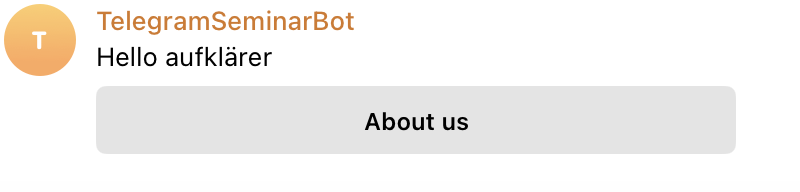

In [ ]:
!pip install groq

Давайте попробуем добавить кнопочку меню бота?

hint: https://docs.python-telegram-bot.org/en/stable/telegram.bot.html#telegram.Bot.set_my_commands

In [ ]:
app = ApplicationBuilder().token(os.getenv('TELEGRAM_KEY')).post_init(post_init).build() # вот так можно поменять инициализатор бота
async def post_init(application: Application) -> None:
    await application.bot.set_my_commands([('about_us', 'Learn about us')])
# и в него завернуть прокидывание дополнительных сеттинов



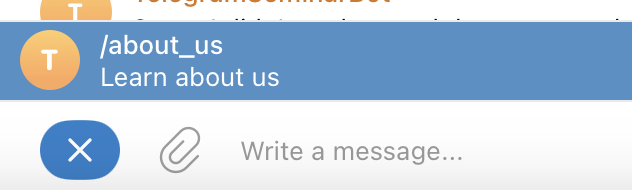


И вот так меню будет выглядеть.

# А теперь давайте отрефакторим все вместе в класс


In [ ]:
import os
from groq import Groq
from telegram import Update, InlineKeyboardButton, InlineKeyboardMarkup
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes, MessageHandler, filters, CallbackQueryHandler


class TelegramBot:
    def __init__(self):
        self.client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
        self.app = ApplicationBuilder().token(os.getenv('TELEGRAM_KEY')).build()
        self.app.add_handler(CommandHandler("start", self.start))
        self.app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, self.handle_message))
        self.app.add_handler(MessageHandler(filters.COMMAND, self.unknown_command))
        self.app.add_handler(CallbackQueryHandler(self.button_handler))

    async def start(self, update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
        """Handle the /start command and send a welcome message with an inline button."""
        keyboard = [
            [InlineKeyboardButton("About us", callback_data='creator_info')]
        ]
        reply_markup = InlineKeyboardMarkup(keyboard)

        await update.message.reply_text(f'Hello {update.effective_user.first_name}', reply_markup=reply_markup)

    async def button_handler(self, update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
        """Handle button interactions from the inline keyboard."""
        query = update.callback_query
        await query.answer()

        if query.data == 'creator_info':
            await query.edit_message_text(text="We are cool people.")

    async def handle_message(self, update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
        """Handle any text message sent by the user."""
        user_message = update.message.text
        response = self.send_to_groq_api(user_message)
        await update.message.reply_text(response)

    def send_to_groq_api(self, message: str) -> str:
        """Send a message to the Groq API and return the response."""
        try:
            chat_completion = self.client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": message,
                    }
                ],
                model="mixtral-8x7b-32768",
            )
            return chat_completion.choices[0].message.content

        except Exception as e:
            return f"An error occurred while communicating with the Groq API: {e}"

    async def unknown_command(self, update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
        """Handle unknown commands."""
        await update.message.reply_text("Sorry, I didn't understand that command.")

    def run(self):
        """Start the bot and begin polling for updates."""
        self.app.run_polling()


if __name__ == "__main__":
    bot = TelegramBot()
    bot.run()


А какие принципы SOLID этот класс нарушает?
https://ru.wikipedia.org/wiki/SOLID_(%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

Класс выше очень неудобно тестировать, для юнит тестов его нужно разделить на более легко тестируемые части. Он нарушает почти все принципы